<a href="https://colab.research.google.com/github/TheSuperiorCoder/lorawan-dos-gzsl/blob/11-27/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lord-seam/dos-attack-lorawan-dataset.git /content/dos-attack-lorawan-dataset/

Cloning into '/content/dos-attack-lorawan-dataset'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 468 (delta 77), reused 175 (delta 70), pack-reused 277 (from 1)
Receiving objects: 100% (468/468), 49.43 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [ ]:
!pip3 install matplotlib scapy torch tqdm xgboost

from scapy.all import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.4 MB/s eta 0:00:00


In [ ]:
import torch
from scapy.all import rdpcap, Raw
import uuid, random, os

max_len = 100  # packet length for fixed vector size

seen_files_dict = {
    0: '/content/dos-attack-lorawan-dataset/pcap_captures/normaltraffic.pcap',
    1: '/content/dos-attack-lorawan-dataset/pcap_captures/joinrequestflood.pcap',
}

unseen_files_dict = {
    0: '/content/dos-attack-lorawan-dataset/pcap_captures/joinrequestreplay.pcap',
    1: '/content/dos-attack-lorawan-dataset/pcap_captures/pulldataflooding.pcap',
    2: str(uuid.uuid4()) + '.pcap',   # random noise
    3: str(uuid.uuid4()) + '.pcap'
}

files_dict = {
    0: '/content/dos-attack-lorawan-dataset/pcap_captures/normaltraffic.pcap',
    1: '/content/dos-attack-lorawan-dataset/pcap_captures/joinrequestflood.pcap',
    2: '/content/dos-attack-lorawan-dataset/pcap_captures/joinrequestreplay.pcap',
    3: '/content/dos-attack-lorawan-dataset/pcap_captures/pulldataflooding.pcap'
}

def extract_pkt(dict_path):
    all_features = []
    all_labels = []

    for label, file_path in dict_path.items():
        if os.path.exists(file_path):
            # Real PCAP file
            packets = rdpcap(file_path)
            for pkt in packets:
                if pkt.haslayer(Raw):
                    raw_bytes = pkt[Raw].load
                    vector = list(raw_bytes[:max_len])
                    if len(vector) < max_len:
                        vector += [0] * (max_len - len(vector))
                    all_features.append(vector)
                    all_labels.append(label)
        elif os.path == str(uuid.uuid4()) + '.pcap':
            # File doesn’t exist → generate random noise
            num_vectors = 10  # adjust how many noise samples per "file"
            for _ in range(num_vectors):
                vector = [random.randint(0, 255) for _ in range(max_len)]
                all_features.append(vector)
                all_labels.append(label)

    X = torch.tensor(all_features, dtype=torch.float)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y

# Example usage
X_all, y_all = extract_pkt(unseen_files_dict)
print(X_all.shape, y_all.shape)


torch.Size([1472, 100]) torch.Size([1472])


In [ ]:
X_seen, y_seen = extract_pkt(seen_files_dict)
X_full, y_full = extract_pkt(files_dict)

print("Seen features:", X_seen.shape)
print("All features:", X_full.shape)

# --- Optional: Split seen into train/test ---

def generate_noise_for_label(label, num_samples=700, max_len=100):
    data = []
    labels = []
    for _ in range(num_samples):
        vec = [random.randint(0, 255) for _ in range(max_len)]
        data.append(vec)
        labels.append(label)
    return torch.tensor(data, dtype=torch.float), torch.tensor(labels, dtype=torch.long)

noise2_X, noise2_y = generate_noise_for_label(2, num_samples=500, max_len=max_len)
noise3_X, noise3_y = generate_noise_for_label(3, num_samples=500, max_len=max_len)

# Concatenate real + noise into training set
X_seen = torch.cat([X_seen, noise2_X, noise3_X], dim=0)
y_seen = torch.cat([y_seen, noise2_y, noise3_y], dim=0)

X_train, X_val, y_train, y_val = train_test_split(
    X_seen, y_seen, test_size=0.2, random_state=123, stratify=y_seen
)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)

X_test = X_full
y_test = y_full

train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


Seen features: torch.Size([1438, 100])
All features: torch.Size([2910, 100])
Train set: torch.Size([1950, 100])
Validation set: torch.Size([488, 100])


In [ ]:
from sklearn.metrics import accuracy_score

model = xgboost.XGBClassifier(
    objective='multi:softmax',
    num_class=len(torch.unique(y_train)),
    use_label_encoder=False,
    n_estimators=100,
    random_state=123,
    eval_metric="mlogloss" # Moved eval_metric to the constructor
)

# Convert tensors to numpy arrays for XGBoost
X_train_np = X_train.squeeze(1).numpy() # Remove the channel dimension
y_train_np = y_train.numpy()
X_val_np = X_val.squeeze(1).numpy()
y_val_np = y_val.numpy()

# Train the model
print("Training XGBoost model...")
eval_set = [(X_train_np, y_train_np), (X_val_np, y_val_np)]
model.fit(
    X_train_np,
    y_train_np,
    eval_set=eval_set,
    verbose=True # Removed eval_metric from here
)
print("XGBoost model training complete.")
evals_result = model.evals_result()

# Evaluate the model on the validation set
y_pred_val = model.predict(X_val_np)
accuracy_val = accuracy_score(y_val_np, y_pred_val)
print(f"Validation Accuracy: {accuracy_val:.2f}")

X_test_np = X_test.squeeze(1).numpy()
y_test_np = y_test.numpy()
y_pred_test = model.predict(X_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
print(f"Test Accuracy: {accuracy_test:.2f}")

Training XGBoost model...
[0]	validation_0-mlogloss:1.04603	validation_1-mlogloss:1.08972
[1]	validation_0-mlogloss:0.84675	validation_1-mlogloss:0.92451
[2]	validation_0-mlogloss:0.70843	validation_1-mlogloss:0.81081


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:32:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[3]	validation_0-mlogloss:0.60568	validation_1-mlogloss:0.73070
[4]	validation_0-mlogloss:0.53275	validation_1-mlogloss:0.67694
[5]	validation_0-mlogloss:0.47228	validation_1-mlogloss:0.63393
[6]	validation_0-mlogloss:0.42777	validation_1-mlogloss:0.60178
[7]	validation_0-mlogloss:0.38962	validation_1-mlogloss:0.57877
[8]	validation_0-mlogloss:0.35977	validation_1-mlogloss:0.56017
[9]	validation_0-mlogloss:0.33825	validation_1-mlogloss:0.54671
[10]	validation_0-mlogloss:0.31402	validation_1-mlogloss:0.53681
[11]	validation_0-mlogloss:0.29501	validation_1-mlogloss:0.52711
[12]	validation_0-mlogloss:0.27778	validation_1-mlogloss:0.52499
[13]	validation_0-mlogloss:0.26430	validation_1-mlogloss:0.52281
[14]	validation_0-mlogloss:0.25088	validation_1-mlogloss:0.52164
[15]	validation_0-mlogloss:0.24041	validation_1-mlogloss:0.51969
[16]	validation_0-mlogloss:0.22838	validation_1-mlogloss:0.51797
[17]	validation_0-mlogloss:0.21705	validation_1-mlogloss:0.51896
[18]	validation_0-mlogloss:0.208

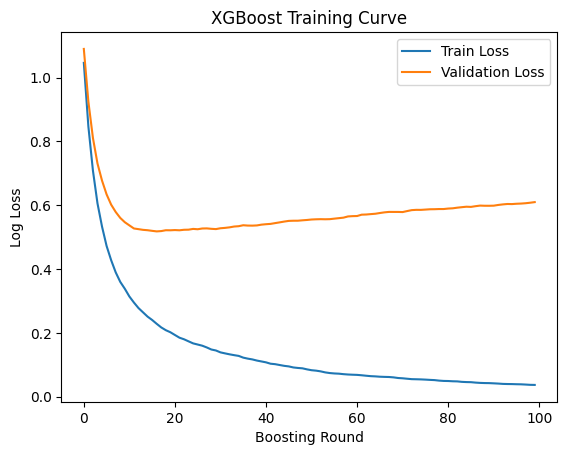

In [ ]:
import matplotlib.pyplot as plt
epochs = range(len(evals_result['validation_0']['mlogloss']))
plt.plot(epochs, evals_result['validation_0']['mlogloss'], label='Train Loss')
plt.plot(epochs, evals_result['validation_1']['mlogloss'], label='Validation Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Training Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

y_pred_val = model.predict(X_val_np)

acc_val = accuracy_score(y_val_np, y_pred_val)
f1_val = f1_score(y_val_np, y_pred_val, average='weighted')  # weighted for multi-class

print(f"Val Accuracy: {acc_val:.3f}")
print(f"Val F1 Score: {f1_val:.3f}")

Val Accuracy: 0.701
Val F1 Score: 0.700


In [ ]:
y_pred_test = model.predict(X_test_np)

acc_val = accuracy_score(y_test_np, y_pred_test)
f1_val = f1_score(y_test_np, y_pred_test, average='weighted')  # weighted for multi-class

print(f"Test Accuracy: {acc_val:.3f}")
print(f"Test F1 Score: {f1_val:.3f}")

Test Accuracy: 0.476
Test F1 Score: 0.315


Val Confusion Matrix:
 [[ 92  25   0   0]
 [ 27 144   0   0]
 [  0   0  59  41]
 [  0   0  53  47]]
Test Confusion Matrix:
 [[557  25   0   0]
 [ 27 829   0   0]
 [451 357   0   0]
 [171 493   0   0]]


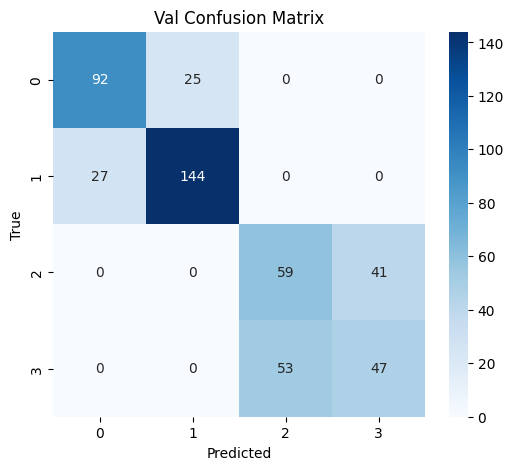

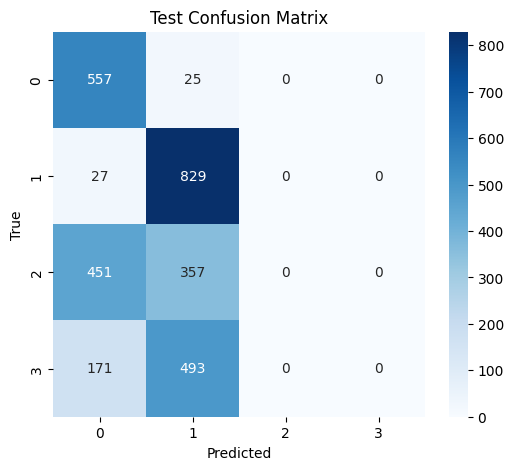

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val_np, y_pred_val) # Corrected: use y_pred_val for validation confusion matrix
cm2 = confusion_matrix(y_test_np, y_pred_test)
print("Val Confusion Matrix:\n", cm)
print("Test Confusion Matrix:\n", cm2)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Val Confusion Matrix')
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
acc_s = accuracy_val  # Validation accuracy as Accuracy on Seen data
acc_u = accuracy_test # Test accuracy as Accuracy on Unseen data

h_mean = (2 * acc_s * acc_u) / (acc_s + acc_u)

print(f"Accuracy on Seen data (Acc_S): {acc_s:.3f}")
print(f"Accuracy on Unseen data (Acc_U): {acc_u:.3f}")
print(f"Harmonic Mean (H-Mean): {h_mean:.3f}")

Accuracy on Seen data (Acc_S): 0.701
Accuracy on Unseen data (Acc_U): 0.476
Harmonic Mean (H-Mean): 0.567
